In [1]:
import tensorflow as tf

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
import shutil
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [17]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    with_info=True,
    as_supervised=True,
    split=['train[:70%]', 'train[70%:]'],
)

num_examples = dataset_info.splits['train'].num_examples
num_classes = dataset_info.features['label'].num_classes

In [20]:
for i, example_image in enumerate(training_set.take(3)):
    print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (333, 500, 3)
Image 2 shape: (212, 320, 3)
Image 3 shape: (240, 320, 3)


In [21]:
num_classes = info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
    num_training_examples += 1

for example in validation_set:
    num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [23]:
IMAGE_RES=224
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [24]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [25]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(5)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

EPOCHS = 20
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/20
81/81 [==============================] - 8s 38ms/step - loss: 0.7687 - accuracy: 0.7069 - val_loss: 0.4376 - val_accuracy: 0.8429
Epoch 2/20
81/81 [==============================] - 2s 31ms/step - loss: 0.3781 - accuracy: 0.8704 - val_loss: 0.3513 - val_accuracy: 0.8756
Epoch 3/20
81/81 [==============================] - 3s 31ms/step - loss: 0.2928 - accuracy: 0.9035 - val_loss: 0.3261 - val_accuracy: 0.8883
Epoch 4/20
81/81 [==============================] - 2s 30ms/step - loss: 0.2473 - accuracy: 0.9233 - val_loss: 0.2976 - val_accuracy: 0.9046
Epoch 5/20
81/81 [==============================] - 2s 30ms/step - loss: 0.2110 - accuracy: 0.9377 - val_loss: 0.2894 - val_accuracy: 0.9055
Epoch 6/20
81/81 [==============================] - 2s 31ms/step - loss: 0.1861 - accuracy: 0.9502 - val_loss: 0.2950 - val_accuracy: 0.9019
Epoch 7/20
81/81 [==============================] - 3s 33ms/step - loss: 0.1645 - accuracy: 0.9552 - val_loss: 0.2897 - val_accuracy: 0.9037
Epoch 8/20
81

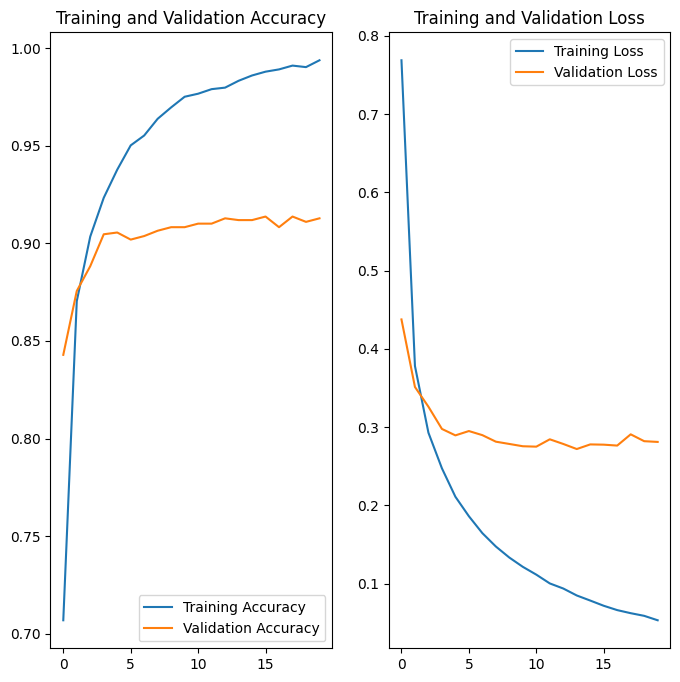

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
class_names = np.array(info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [30]:
image_batch, label_batch = next(iter(train_batches.take(1)))

In [31]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 1s 507ms/step


array(['roses', 'daisy', 'daisy', 'tulips', 'sunflowers', 'sunflowers',
       'daisy', 'dandelion', 'tulips', 'dandelion', 'roses', 'sunflowers',
       'sunflowers', 'tulips', 'daisy', 'dandelion', 'sunflowers',
       'dandelion', 'tulips', 'roses', 'dandelion', 'daisy', 'dandelion',
       'dandelion', 'daisy', 'dandelion', 'tulips', 'roses', 'dandelion',
       'daisy', 'dandelion', 'roses'], dtype='<U10')

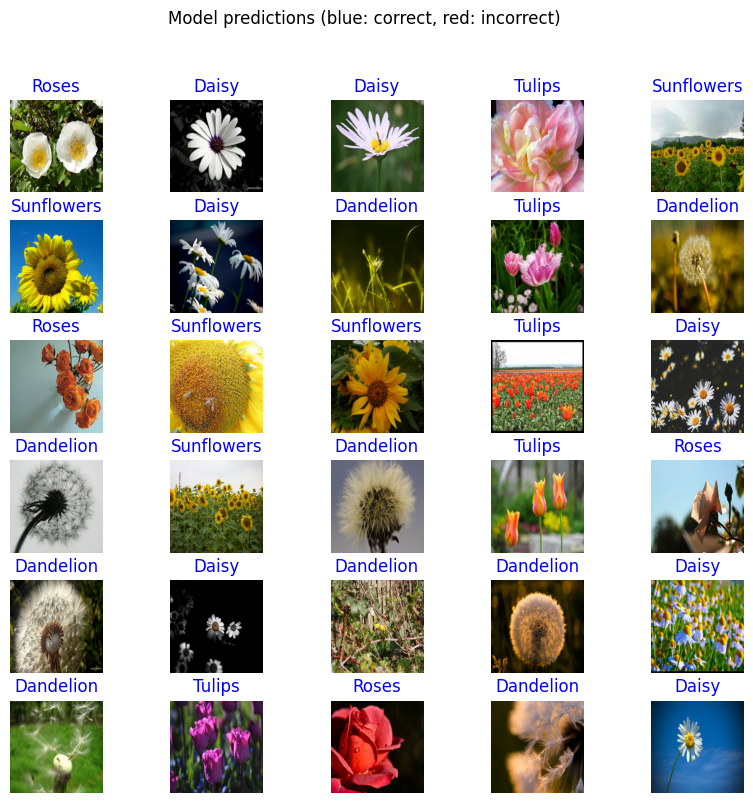

In [33]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")